In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import  transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

import time

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# DataLoader

In [4]:
class CustomDataset(Dataset):

    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform
        self.files_paths = [f for f in os.listdir(self.path) if f.endswith('.png')]
        self.data = [Image.open(os.path.join(self.path, f)).convert('RGB') for f in os.listdir(self.path) if f.endswith('.png')]
        self.labels = [f.split('-')[0] for f in self.files_paths]
        self.labels = [0 if x == 'humans' else 1 for x in self.labels]
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image = self.data[index]
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
def get_normalization_values(path):
    """
    Compute the mean and standard deviation of the pixel values for each channel
    in the images stored in the specified folder.
    """
    red_values = []
    green_values = []
    blue_values = []

    for file in os.listdir(path):
        if file.endswith('.png'):
            image = Image.open(os.path.join(path, file))
            image_np = np.array(image)

            red, green, blue = image_np[:,:,0], image_np[:,:,1], image_np[:,:,2]

            red_values.append(red)
            green_values.append(green)
            blue_values.append(blue)

    red_mean = np.mean(red_values)/255
    green_mean = np.mean(green_values)/255
    blue_mean = np.mean(blue_values)/255

    red_std = np.std(red_values)/255
    green_std = np.std(green_values)/255
    blue_std = np.std(blue_values)/255

    return (red_mean, green_mean, blue_mean), (red_std, green_std, blue_std)


In [6]:
mean, std = get_normalization_values("data/train/")

mean = torch.tensor(mean)
std = torch.tensor(std)

In [7]:
print(mean, std)
train_batch_size = 128
test_batch_size = 128

channels = 3
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train = CustomDataset(path = "data/train/",  transform=transform)
test = CustomDataset(path = "data/validation/", transform=transform)

# train = datasets.ImageFolder("data2/train", transform)
# test = datasets.ImageFolder("data2/test", transform)

train_loader = DataLoader(train, batch_size=train_batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test, batch_size=test_batch_size, shuffle=True, pin_memory=True)

tensor([0.4293, 0.4012, 0.3861], dtype=torch.float64) tensor([0.2725, 0.2533, 0.2564], dtype=torch.float64)


# Model Nostre

In [8]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
def get_accuracy(y_true, y_prob):
    assert y_true.ndim == 1 and y_prob.ndim == 1
    y_prob = y_prob > 0.5
    return (y_true == y_prob).sum().item()  

In [10]:
def train_model(model, num_epochs, optimizer, criterion):
    start = time.time()
    tr_loss = np.zeros((num_epochs))
    te_loss = np.zeros((num_epochs))

    tr_acc = np.zeros((num_epochs))
    te_acc = np.zeros((num_epochs))

    best_acc = 0

    for epoch in range(num_epochs):
        
#         train_loss = test_loss = train_acc = test_acc = 0
        train_loss = 0
        test_loss = 0

        train_acc = 0
        test_acc = 0
     

        model.train()

        for i, (data, labels) in enumerate(train_loader):
            print("a")
            data, labels = data.to(device), labels.to(device)
            print("b")
            optimizer.zero_grad(set_to_none=True)
            print("c")
            outputs = model(data)
            print("d")
            loss = criterion(outputs,  labels.type(torch.float32))
            loss.backward()
            
            optimizer.step()

            train_loss += loss.item()
            train_acc += get_accuracy(labels, outputs)
       

        model.eval()
        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(device), labels.to(device)

                outputs = model(data)
                outputs = outputs.squeeze()
                
                loss = criterion(outputs,  labels.type(torch.float32))
                test_loss += loss.item()

                test_acc += get_accuracy(labels, outputs)
                  

        # compute the average loss and accuracy for each epoch
        train_loss /= len(train_loader)
        test_loss /= len(test_loader)
        train_acc /= len(train)
        test_acc /= len(test)

        tr_loss[epoch] = train_loss
        te_loss[epoch] = test_loss
        tr_acc[epoch] = train_acc
        te_acc[epoch] = test_acc

        if test_acc > best_acc:
          best_acc = test_acc
          best_model = model
          print(f"BEST SO FAR: {round(best_acc,4)}")

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
    
    time_spent = time.time()-start
    print(f"Time spent {round(time_spent, 2)}, Time per Epoch {round(time_spent/num_epochs, 2)}")

    plt.plot(tr_acc, label='Train accuracy')
    plt.plot(te_acc, label='Test accuracy')
    plt.legend()
    plt.show()

    plt.plot(tr_loss, label='Train accuracy')
    plt.plot(te_loss, label='Test accuracy')
    plt.legend()
    plt.show()
    
    return best_model, best_acc

## CNN_1

In [11]:
class net_CNN_1(nn.Module):
    def __init__(self, channels, feature_size):
        super().__init__()
        self.main = nn.Sequential(
            self.block(channels, feature_size, 3, 2, 1), #300x300 -> 75x75 
            self.block(feature_size, feature_size*2, 3, 2, 1), # 75x75 -> 19x19
            self.block(feature_size*2, feature_size*4, 3, 2, 1), # 19x19 -> 5x5
            self.block(feature_size*4, feature_size*8, 3, 2, 1), #5x5 -> 1x1
            nn.Flatten(),

            nn.Linear(feature_size*8, 8), 
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(8, 4), 
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(4, 1)
        )
    
    def forward(self, x):
        return self.main(x).squeeze()

    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

In [12]:
lr_CNN_1 = 0.01
feature_size_CNN_1 = 2
num_epochs_CNN_1 = 5

CNN_1 = net_CNN_1(channels, feature_size_CNN_1).to(device)
CNN_1.apply(weights_init)

criterion_CNN_1 = nn.BCEWithLogitsLoss().to(device)
optimizer_CNN_1 = torch.optim.SGD(CNN_1.parameters(), lr=lr_CNN_1, momentum=0.9)

pytorch_total_params_CNN_1 = sum(p.numel() for p in CNN_1.parameters())
print("Total number of parameters CNN: ", pytorch_total_params_CNN_1)
# summary(CNN_1, (3, 300, 300))

Total number of parameters CNN:  1803


a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
BEST SO FAR: 0.4459
Epoch 1/5, Train Loss: 0.6702, Test Loss: 0.6636, Train Acc: 0.5193, Test Acc: 0.4459
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
Epoch 2/5, Train Loss: 0.5462, Test Loss: 0.6268, Train Acc: 0.5193, Test Acc: 0.4459
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
a
b
c
d
BEST SO FAR: 0.8182
Epoch 3/5, Train Los

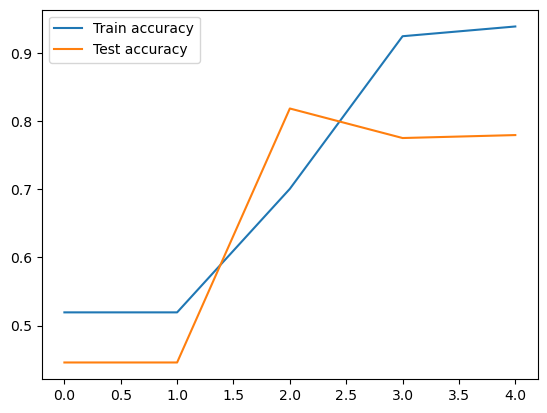

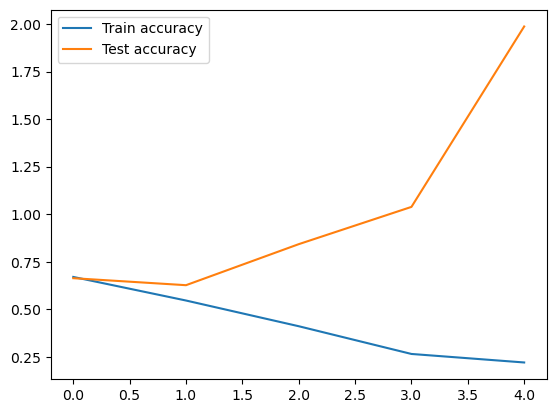

Saving best CNN_1 with accuracy 0.8182


RuntimeError: Parent directory /content/drive/My Drive/practica2/models/CNN1 does not exist.

In [13]:
best_CNN_1, acc = train_model(CNN_1, num_epochs_CNN_1, optimizer_CNN_1, criterion_CNN_1)

print(f"Saving best CNN_1 with accuracy {round(acc,4)}")
torch.save(best_CNN_1.state_dict(), "/content/drive/My Drive/practica2/models/CNN1/"+str(round(acc, 4))+".pth")

## CNN_2

In [ ]:
class net_CNN_2(nn.Module):
    def __init__(self, channels, feature_size):
        super().__init__()
        self.main = nn.Sequential(
            self.block(channels, feature_size, 5, 3, 0), #300x300 -> 100x100
            self.block(feature_size, feature_size*2, 3, 2, 1), #100x100 -> 50x50
            self.block(feature_size*2, feature_size*4, 5, 3, 1), # 50x50 -> 16x16
            self.block(feature_size*4, feature_size*8, 5, 3, 1), # 16x16 -> 5x5
            self.block(feature_size*8, feature_size*4, 3, 2, 1), # 5x5 -> 3x3
            self.block(feature_size*4, feature_size*2, 3, 2, 1), # 3x3 -> 2x2
            nn.Flatten(),

            nn.Linear(feature_size*2*2*2, feature_size*2*2), # 16 -> 8
            nn.ReLU(),

            nn.Dropout(0.5),

            nn.Linear(feature_size*2*2, feature_size*2), # 8 -> 4 
            nn.ReLU(),

            nn.Dropout(0.25),
            
            nn.Linear(feature_size*2, 1)
        )
    
    def forward(self, x):
        return self.main(x).squeeze()

    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

In [ ]:
lr_CNN_2 = 0.003
feature_size_CNN_2 = 2
num_epochs_CNN_2 = 50

CNN_2 = net_CNN_2(channels, feature_size_CNN_2).to(device)
CNN_2.apply(weights_init)

criterion_CNN_2 = nn.BCEWithLogitsLoss().to(device)
optimizer_CNN_2 = torch.optim.SGD(CNN_2.parameters(), lr=lr_CNN_2, momentum = 0.5, nesterov = True)

pytorch_total_params_CNN_2 = sum(p.numel() for p in CNN_2.parameters())
print("Total number of parameters: ", pytorch_total_params_CNN_2)
summary(CNN_2, (3, 300, 300))

In [ ]:
best_CNN_2, acc = train_model(CNN_2, num_epochs_CNN_2, optimizer_CNN_2, criterion_CNN_2)

print(f"Saving best CNN2 with accuracy {round(acc,4)}")
torch.save(best_CNN_2.state_dict(), "/content/drive/My Drive/practica2/models/CNN2/"+str(round(acc, 4))+".pth")

## FCNN

In [ ]:
class net_FCN(nn.Module):
    def __init__(self, channels, feature_size):
        super().__init__()
        self.main = nn.Sequential(
            self.block(channels, feature_size, 5, 3, 0), # 300x300 --> 99x99
            self.block(feature_size, feature_size*2, 5, 3, 0), # 99x99 --> 32x32
            self.block(feature_size*2, feature_size*4, 5, 3, 0), # 32x32 --> 10x10
            self.block(feature_size*4, feature_size*2, 3, 2, 1), # 10x10 --> 5x5
            self.block(feature_size*2, feature_size, 3, 2, 1), # 5x5 --> 3x3
            nn.Conv2d(feature_size, 1, 3, 2, 0) # 3x3 -> 1x1
        )
    
    def forward(self, x):
        return self.main(x).squeeze()

    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

In [ ]:
lr_FCN = 0.002
feature_size_FCN = 2
num_epochs_FCN = 50

# with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
#     with record_function("model_inference"):
FCN = net_FCN(channels, feature_size_FCN).to(device)
FCN.apply(weights_init)

criterion_FCN = nn.BCEWithLogitsLoss().to(device)
optimizer_FCN = torch.optim.SGD(FCN.parameters(), lr=lr_FCN, momentum=0.5)

pytorch_total_params_FCN = sum(p.numel() for p in FCN.parameters())
print("Total number of parameters FCN: ", pytorch_total_params_FCN)
summary(FCN, (3, 300, 300))

In [ ]:
best_FCN, acc = train_model(FCN, num_epochs_FCN, optimizer_FCN, criterion_FCN)

print(f"Saving best FCN with accuracy {round(acc,4)}")
torch.save(best_FCN.state_dict(), "/content/drive/My Drive/practica2/models/FCNN/"+str(round(acc, 4))+".pth")

## Ensemble

In [ ]:
# AÑADIR SIGMOID

class net_Ensemble(torch.nn.Module):
    def __init__(self, cnn1, cnn2, fcn):
        super().__init__()

        self.cnn1 = cnn1
        self.cnn2 = cnn2
        self.fcn1 = fcn
       
        self.fc = nn.Linear(3, 1)

        self.sig = nn.Sigmoid()
        
        # freeze the weights of the pre-trained models
        for param in self.cnn1.parameters():
            param.requires_grad = False
        for param in self.cnn2.parameters():
            param.requires_grad = False
        for param in self.fcn1.parameters():
            param.requires_grad = False

    def forward(self, data):

        X_1 = self.sig(self.cnn1(data))
        X_2 = self.sig(self.cnn2(data))
        X_3 = self.sig(self.fcn1(data))
        
        X = torch.stack([X_1, X_2, X_3], dim=1)
        X = self.fc(F.relu(X))
   
        return X.squeeze()

In [ ]:
lr_Ensemble = 0.1

num_epochs_Ensemble = 50

model1 = net_CNN_1(3,2)
model2 = net_CNN_2(3,2)
model3 = net_FCN(3,2)

model1.load_state_dict(torch.load("/content/drive/My Drive/practica2/models/CNN1/0.9048.pth"))
model2.load_state_dict(torch.load("/content/drive/My Drive/practica2/models/CNN2/0.9394.pth"))
model3.load_state_dict(torch.load("/content/drive/My Drive/practica2/models/FCNN/0.8918.pth"))

ensemble = net_Ensemble(model1, model2, model3).to(device)

# ensemble = net_Ensemble(CNN_1, CNN_2, FCN).to(device)

ensemble.apply(weights_init)

criterion_Ensemble= nn.BCEWithLogitsLoss().to(device)

optimizer_Ensemble = torch.optim.SGD(ensemble.parameters(), lr=lr_Ensemble, momentum = 0.9)

pytorch_total_params_Ensemble = sum(p.numel() for p in ensemble.parameters())
pytorch_learn_params_Ensemble = sum(p.numel() for p in ensemble.parameters() if p.requires_grad)
print("Total number of parameters ensemble: ", pytorch_total_params_Ensemble)
print("Number of learnable parameters ensemble: ", pytorch_learn_params_Ensemble)

summary(ensemble, (3, 300, 300))

In [ ]:
best_ensemble, acc = train_model(ensemble, num_epochs_Ensemble, optimizer_Ensemble, criterion_Ensemble)

print(f"Saving best ENSEMBLE with accuracy {round(acc,4)}")
torch.save(best_ensemble.state_dict(), "/content/drive/My Drive/practica2/models/ENSEMBLE/"+str(round(acc, 4))+".pth")

In [ ]:
print(best_ensemble.fc[0].weight)

In [ ]:
model1 = net_CNN_1(3,2)
model1.load_state_dict(torch.load("models/CNN1_1.pth"))

model2 = net_CNN_2(3,2)
model2.load_state_dict(torch.load("models/CNN2_1.pth"))

model3 = net_FCN(3,2)
model3.load_state_dict(torch.load("models/FCN_1.pth"))

model4 = net_Ensemble(model1, model2, model3)
model4.load_state_dict(torch.load("models/Ensemble_1.pth"))

In [ ]:
real_human = CustomDataset(path = "/content/drive/My Drive/practica2/real/human/", transform=transform)
real_horse = CustomDataset(path = "/content/drive/My Drive/practica2/real/horse/", transform=transform)

loader_human = DataLoader(real_human, batch_size=64)
loader_horse = DataLoader(real_horse, batch_size=64)

In [ ]:
# Loop through the human data
acc1 = acc2 = acc3 = acc4 = 0
for i, (data, labels) in enumerate(loader_human):
    # Get the inputs and labels
    # Make predictions with the models
    output1 = model1(data)
    output2 = model2(data)
    output3 = model3(data)
    output4 = model4(data)

    acc1 += get_accuracy(labels, output1)
    acc2 += get_accuracy(labels, output2)
    acc3 += get_accuracy(labels, output3)
    acc4 += get_accuracy(labels, output4)

acc1 = round(acc1 / len(real_human), 4)
acc2 = round(acc2 / len(real_human), 4)
acc3 = round(acc3 / len(real_human), 4)
acc4 = round(acc4 / len(real_human), 4)
    # Print the predictions
print("Accuracy for real humans:")
print(f"CNN1 {acc1}, CNN2 {acc2}, FCNN {acc3}, Ensemble {acc4}")
      
acc1 = acc2 = acc3 = acc4 = 0
for i, (data, labels) in enumerate(loader_horse):
    # Get the inputs and labels
    # Make predictions with the models
    output1 = model1(data)
    output2 = model2(data)
    output3 = model3(data)
    output4 = model4(data)

    acc1 += get_accuracy(labels, output1)
    acc2 += get_accuracy(labels, output2)
    acc3 += get_accuracy(labels, output3)
    acc4 += get_accuracy(labels, output4)

acc1 = round(acc1 / len(real_horse), 4)
acc2 = round(acc2 / len(real_horse), 4)
acc3 = round(acc3 / len(real_horse), 4)
acc4 = round(acc4 / len(real_horse), 4)
    # Print the predictions
print("Accuracy for real horses:")
print(f"CNN1 {acc1}, CNN2 {acc2}, FCNN {acc3}, Ensemble {acc4}")

In [ ]:
# Loop through the human data
acc1 = acc2 = acc3 = acc4 = 0
for i, (data, labels) in enumerate(loader_human):
    data, labels = data.to(device), labels.to(device)

    output1 = CNN_1(data)
    output2 = CNN_2(data)
    output3 = FCN(data)
    output4 = model(data)

    acc1 += get_accuracy(labels, output1)
    acc2 += get_accuracy(labels, output2)
    acc3 += get_accuracy(labels, output3)
    acc4 += get_accuracy(labels, output4)

acc1 = round(acc1 / len(real_human), 4)
acc2 = round(acc2 / len(real_human), 4)
acc3 = round(acc3 / len(real_human), 4)
acc4 = round(acc4 / len(real_human), 4)
    # Print the predictions
print("Accuracy for real humans:")
print(f"CNN1 {acc1}, CNN2 {acc2}, FCNN {acc3}, Ensemble {acc4}")
      
acc1 = acc2 = acc3 = acc4 = 0
for i, (data, labels) in enumerate(loader_horse):
    data, labels = data.to(device), labels.to(device)

    output1 = CNN_1(data)
    output2 = CNN_2(data)
    output3 = FCN(data)
    output4 = model(data)

    acc1 += get_accuracy(labels, output1)
    acc2 += get_accuracy(labels, output2)
    acc3 += get_accuracy(labels, output3)
    acc4 += get_accuracy(labels, output4)

acc1 = round(acc1 / len(real_horse), 4)
acc2 = round(acc2 / len(real_horse), 4)
acc3 = round(acc3 / len(real_horse), 4)
acc4 = round(acc4 / len(real_horse), 4)
    # Print the predictions
print("Accuracy for real horses:")
print(f"CNN1 {acc1}, CNN2 {acc2}, FCNN {acc3}, Ensemble {acc4}")